# Analyzing Agricultural Fields and Temperature Patterns in India using Lonboard

**Table of Contents**

1. [Data Overview](#data-overview)
2. [Loading and Visualizing Geospatial Data](#loading-and-visualizing-geospatial-data)
3. [Extracting Temperature Data from ERA5 Datasets](#extracting-temperature-data-from-era5-datasets)
4. [Processing and Saving ERA5 Data](#processing-and-saving-era5-data)
5. [Extracting Time Series for Field Centroids](#extracting-time-series-for-field-centroids)
6. [Analyzing Temperature Patterns Across Districts](#analyzing-temperature-patterns-across-districts)
7. [Comparing Temperature Patterns Across Multiple Districts](#comparing-temperature-patterns-across-multiple-districts)
8. [Lonboard - Scalable Dynamic Visualization on Maps](#lonboard---scalable-dynamic-visualization-on-maps)


This tutorial demonstrates how to work with geospatial data in Python to analyze agricultural fields and temperature patterns across different districts in India. We'll use libraries like GeoPandas, Xarray, and Matplotlib to:

- Load and visualize field boundaries and district shapefiles.
- Extract temperature time series data from ERA5 datasets.
- Analyze and visualize temperature patterns across selected districts.

## Data Overview
We'll be working with:

- Shapefiles for field boundaries and districts in India.
- ERA5 temperature datasets from the Microsoft Planetary Computer.


Make sure you have the necessary data files in your working directory:
- Field boundaries: data/india-crop-boundary/india_10k_fields.shp
- Karnataka districts: data/KA_subdistrict.shp
- Madhya Pradesh districts: data/MP_subdistrict/state_MADHYA PRADESH.shp

## 1. Loading and Visualizing Geospatial Data

First, let's import the required libraries and load the shapefiles.

In [1]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

#### Load Field Boundaries and District Shapefiles

In [2]:
# Load field boundaries
fields_gdf = gpd.read_file("data/india-crop-boundary/india_10k_fields.shp")

# Load district boundaries for Karnataka and Madhya Pradesh
karnataka_districts = gpd.read_file("data/KA_subdistrict.shp")
madhyapradesh_districts = gpd.read_file("data/MP_subdistrict/state_MADHYA PRADESH.shp")

#### Inspect the DataFrames

In [3]:
print("Fields GeoDataFrame shape:", fields_gdf.shape)
print("Karnataka districts shape:", karnataka_districts.shape)
print("Madhya Pradesh districts shape:", madhyapradesh_districts.shape)

Fields GeoDataFrame shape: (10013, 3)
Karnataka districts shape: (236, 8)
Madhya Pradesh districts shape: (425, 4)


#### Visualize the Districts and Fields

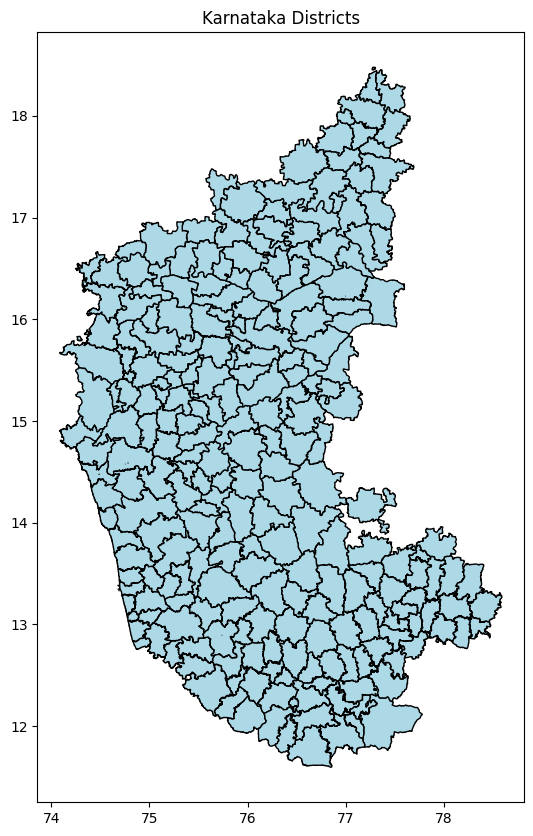

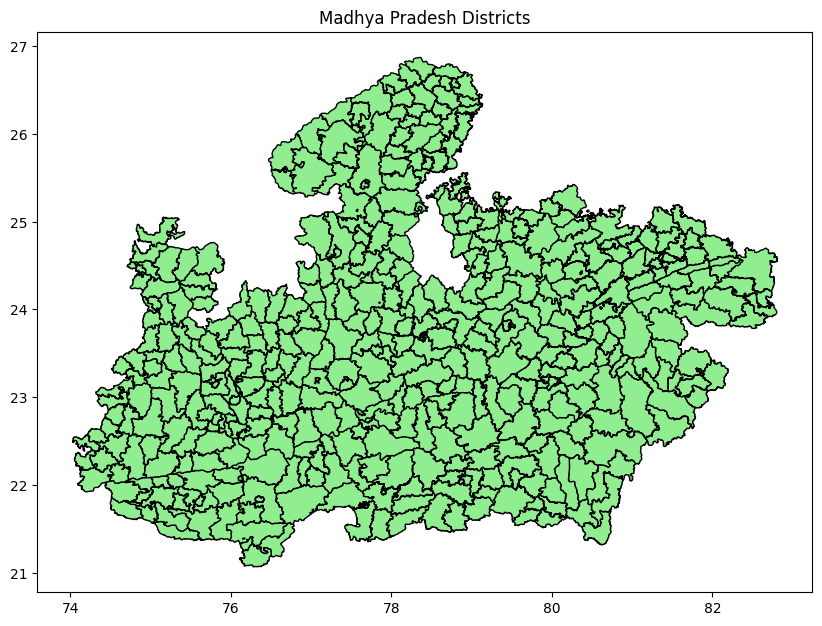

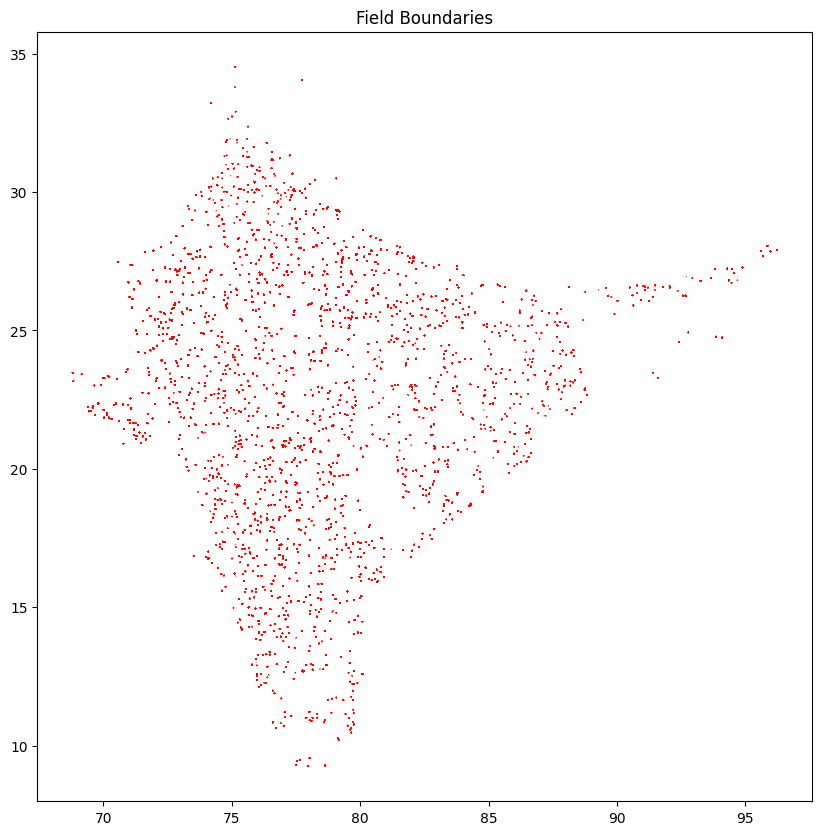

In [4]:
# Plot Karnataka districts
karnataka_districts.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')
plt.title('Karnataka Districts')
plt.show()

# Plot Madhya Pradesh districts
madhyapradesh_districts.plot(figsize=(10, 10), edgecolor='black', facecolor='lightgreen')
plt.title('Madhya Pradesh Districts')
plt.show()

# Plot field boundaries
fields_gdf.plot(figsize=(10, 10), color='none', edgecolor='red')
plt.title('Field Boundaries')
plt.show()

## 2. Extracting Temperature Data from ERA5 Datasets

We'll extract temperature time series data for the fields using ERA5 datasets.

### Load ERA5 Temperature Data

First, we need to access the ERA5 datasets from the Microsoft Planetary Computer.

In [5]:
import xarray as xr
import pystac_client
from datetime import datetime
import planetary_computer

# Define spatial and temporal parameters
india_bbox = [68.1, 6.5, 97.4, 37.1]  # Bounding box for India
datetime_range = "2020-01-01/2020-12-31"

# Initialize STAC client
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

# Search for ERA5 data
search = catalog.search(
    collections=["era5-pds"],
    bbox=india_bbox,
    datetime=datetime_range,
    query={"era5:kind": {"eq": "an"}}  # Analysis data only
)

# Fetch matching items
items = search.item_collection()
print(f"Number of matching items: {len(items)}")

Number of matching items: 12


### Load and Concatenate ERA5 Datasets

In [6]:
datasets = []
for item in reversed(items):
    asset = item.assets["air_temperature_at_2_metres"]
    signed_asset = planetary_computer.sign(asset)
    
    ds = xr.open_dataset(
        signed_asset.href,
        **signed_asset.extra_fields.get("xarray:open_kwargs", {})
    ).sel(
        lat=slice(india_bbox[3], india_bbox[1]),
        lon=slice(india_bbox[0], india_bbox[2])
    )
    datasets.append(ds)

# Concatenate datasets along the time dimension
era5_ds = xr.concat(datasets, dim="time")
era5_ds = era5_ds.sortby("time")

### Inspect the Dataset

In [8]:
print(era5_ds)

<xarray.Dataset> Size: 506MB
Dimensions:                      (time: 8784, lat: 123, lon: 117)
Coordinates:
  * lat                          (lat) float32 492B 37.0 36.75 36.5 ... 6.75 6.5
  * lon                          (lon) float32 468B 68.25 68.5 ... 97.0 97.25
  * time                         (time) datetime64[ns] 70kB 2020-01-01 ... 20...
Data variables:
    air_temperature_at_2_metres  (time, lat, lon) float32 506MB dask.array<chunksize=(372, 88, 27), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts


## 3. Processing and Saving ERA5 Data

We'll process the ERA5 data by resampling it to daily and weekly means and then save it in Zarr format for efficient access.

### Resample Data to Daily and Weekly Means

In [9]:
# Compute the dataset (load data into memory)
era5_ds = era5_ds.compute()

# Resample to daily mean
era5_daily_ds = era5_ds.resample(time='D').mean()

# Resample to weekly mean
era5_weekly_ds = era5_ds.resample(time='W').mean()

### Save Datasets in Zarr Format

In [10]:
def save_zarr(ds, time_resolution):
    """Save the dataset in Zarr format with appropriate chunking."""
    time_len = len(ds.time)
    chunks = {'time': time_len, 'lat': 1, 'lon': 1}
    encoding = {'air_temperature_at_2_metres': {'chunks': (time_len, 1, 1)}}
    
    output_path = f"data/{time_resolution}_air_temperature.zarr"
    print(f"Saving {time_resolution} data to {output_path}")
    ds.to_zarr(output_path, encoding=encoding, mode='w')

# Save datasets
save_zarr(era5_ds, "hourly")
save_zarr(era5_daily_ds, "daily")
save_zarr(era5_weekly_ds, "weekly")

Saving hourly data to data/hourly_air_temperature.zarr
Saving daily data to data/daily_air_temperature.zarr
Saving weekly data to data/weekly_air_temperature.zarr


## 4. Extracting Time Series for Field Centroids

We'll extract temperature time series data for the centroids of selected fields.

### Define a Function to Extract Time Series

In [11]:
def extract_timeseries_for_centroid(ds, geometry, var_name='air_temperature_at_2_metres'):
    """
    Extract a time series from an xarray Dataset using the centroid of a geometry.
    """
    # Get the centroid coordinates
    centroid = geometry.centroid
    lon, lat = centroid.x, centroid.y
    
    # Extract time series using nearest neighbor selection
    point_data = ds[var_name].sel(
        lat=lat,
        lon=lon,
        method='nearest'
    )
    
    # Convert to pandas Series
    time_series = point_data.to_series()
    
    return time_series

### Load the Weekly Dataset

In [12]:
# Load the weekly dataset
ds_weekly = xr.open_zarr("data/weekly_air_temperature.zarr")

### Extract and Plot Time Series for a Single Field

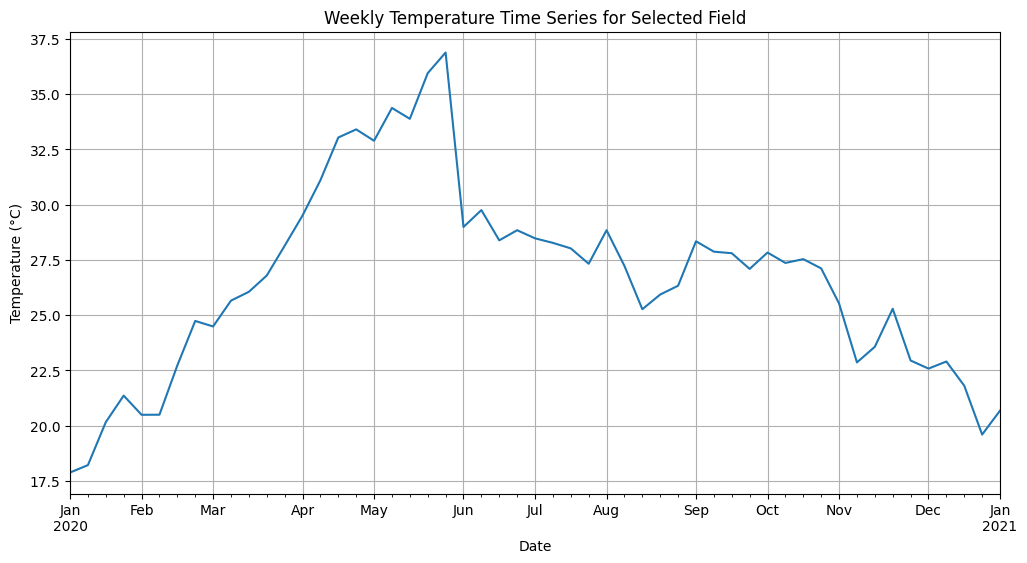

In [13]:
# Select a geometry (e.g., the 21st field)
geometry = fields_gdf.geometry.iloc[20]

# Extract time series
ts = extract_timeseries_for_centroid(ds_weekly, geometry)
ts_celsius = ts - 273.15  # Convert from Kelvin to Celsius

# Plot the results
ts_celsius.plot(figsize=(12, 6))
plt.title('Weekly Temperature Time Series for Selected Field')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## 5. Analyzing Temperature Patterns Across Districts

We'll analyze temperature patterns across different districts by plotting the temperature time series for fields within those districts.

### Spatial Join Fields with Districts

In [14]:
# Ensure the coordinate reference systems match
fields_gdf = fields_gdf.to_crs(karnataka_districts.crs)

# Spatial join fields with Karnataka districts
fields_karnataka = gpd.sjoin(
    fields_gdf,
    karnataka_districts,
    how='inner',
    predicate='within'
)

# Spatial join fields with Madhya Pradesh districts
fields_madhyapradesh = gpd.sjoin(
    fields_gdf,
    madhyapradesh_districts,
    how='inner',
    predicate='within'
)

### Select Fields from Specific Districts

In [15]:
# Select fields from specific districts
belagavi_fields = fields_karnataka[fields_karnataka['district'] == "Belagavi"]
vijayapura_fields = fields_karnataka[fields_karnataka['district'] == "Vijayapura"]
dhar_fields = fields_madhyapradesh[fields_madhyapradesh['district'] == "Dhar"]

### Define a Function to Plot Time Series for Multiple Fields

In [16]:
def plot_district_temperature(fields_df, ds, district_name):
    """
    Plot the temperature time series for all fields in a district.
    """
    # Extract time series for all fields
    time_series_list = []
    for _, row in fields_df.iterrows():
        geometry = row.geometry
        ts = extract_timeseries_for_centroid(ds, geometry)
        ts.name = f"Field {row.name}"
        time_series_list.append(ts)
    
    # Combine all series into a DataFrame
    import pandas as pd
    df_temps = pd.concat(time_series_list, axis=1)
    
    # Plot all time series
    plt.figure(figsize=(15, 10))
    plt.plot(df_temps.index, df_temps.values, alpha=0.2, color='blue', linewidth=1)
    
    # Plot mean and standard deviation
    mean_temp = df_temps.mean(axis=1)
    std_temp = df_temps.std(axis=1)
    plt.plot(df_temps.index, mean_temp, color='red', linewidth=2, label='Mean Temperature')
    plt.fill_between(df_temps.index,
                     mean_temp - std_temp,
                     mean_temp + std_temp,
                     color='red',
                     alpha=0.2,
                     label='±1 Std Dev')
    
    # Customize plot
    plt.title(f'Weekly Temperature Time Series for {district_name} Fields (2020)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (K)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Plot Temperature Time Series for Selected Districts

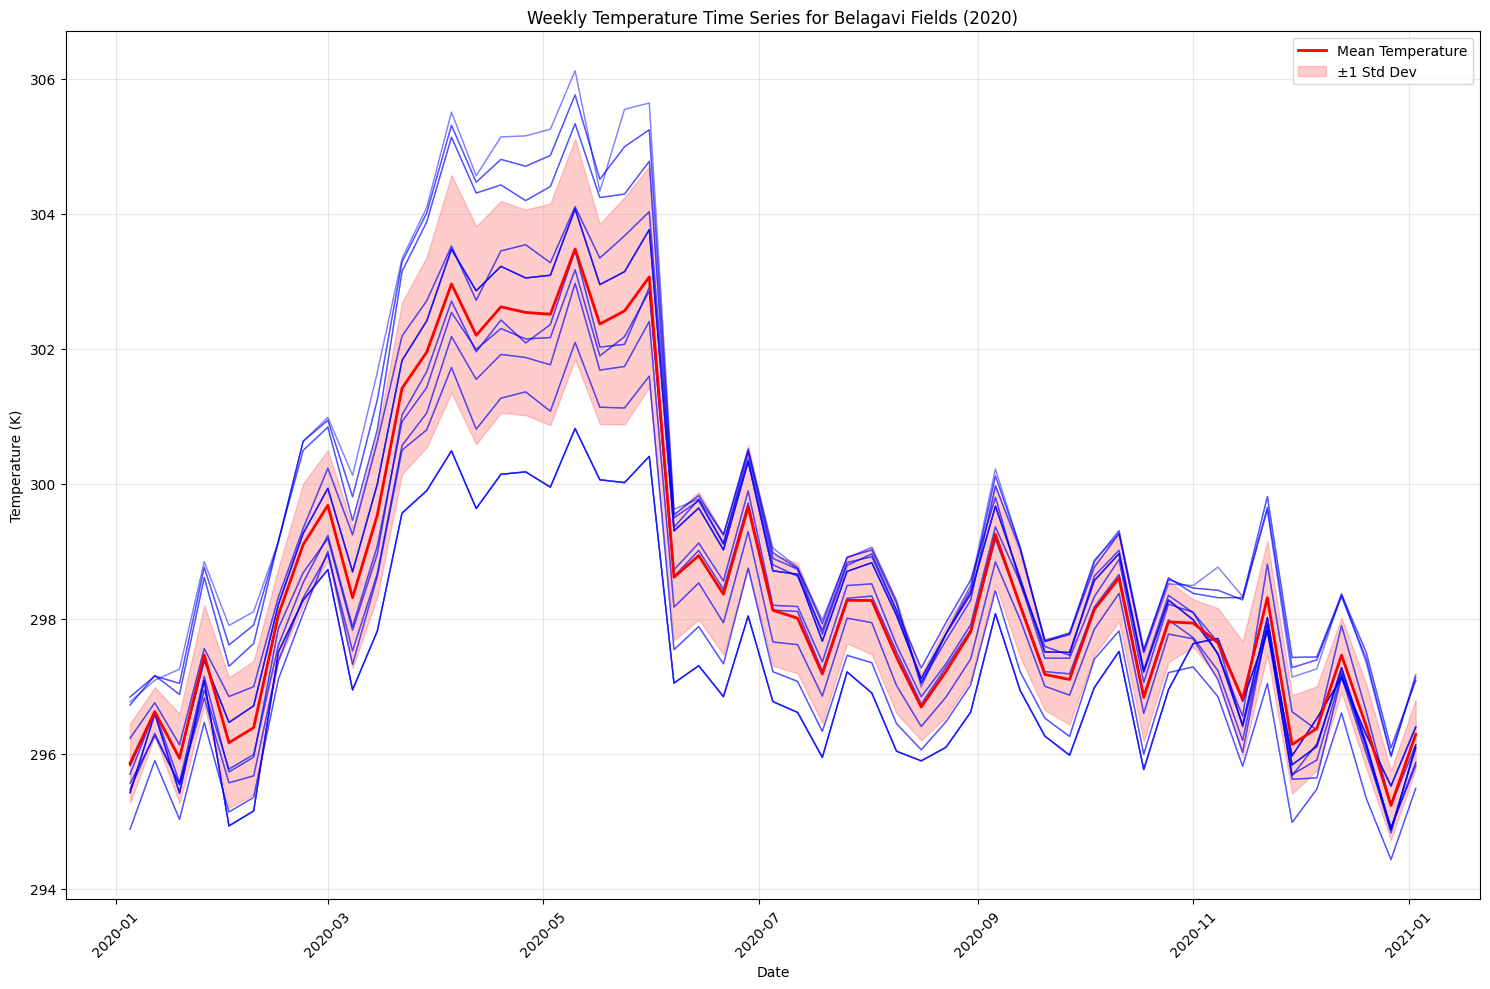

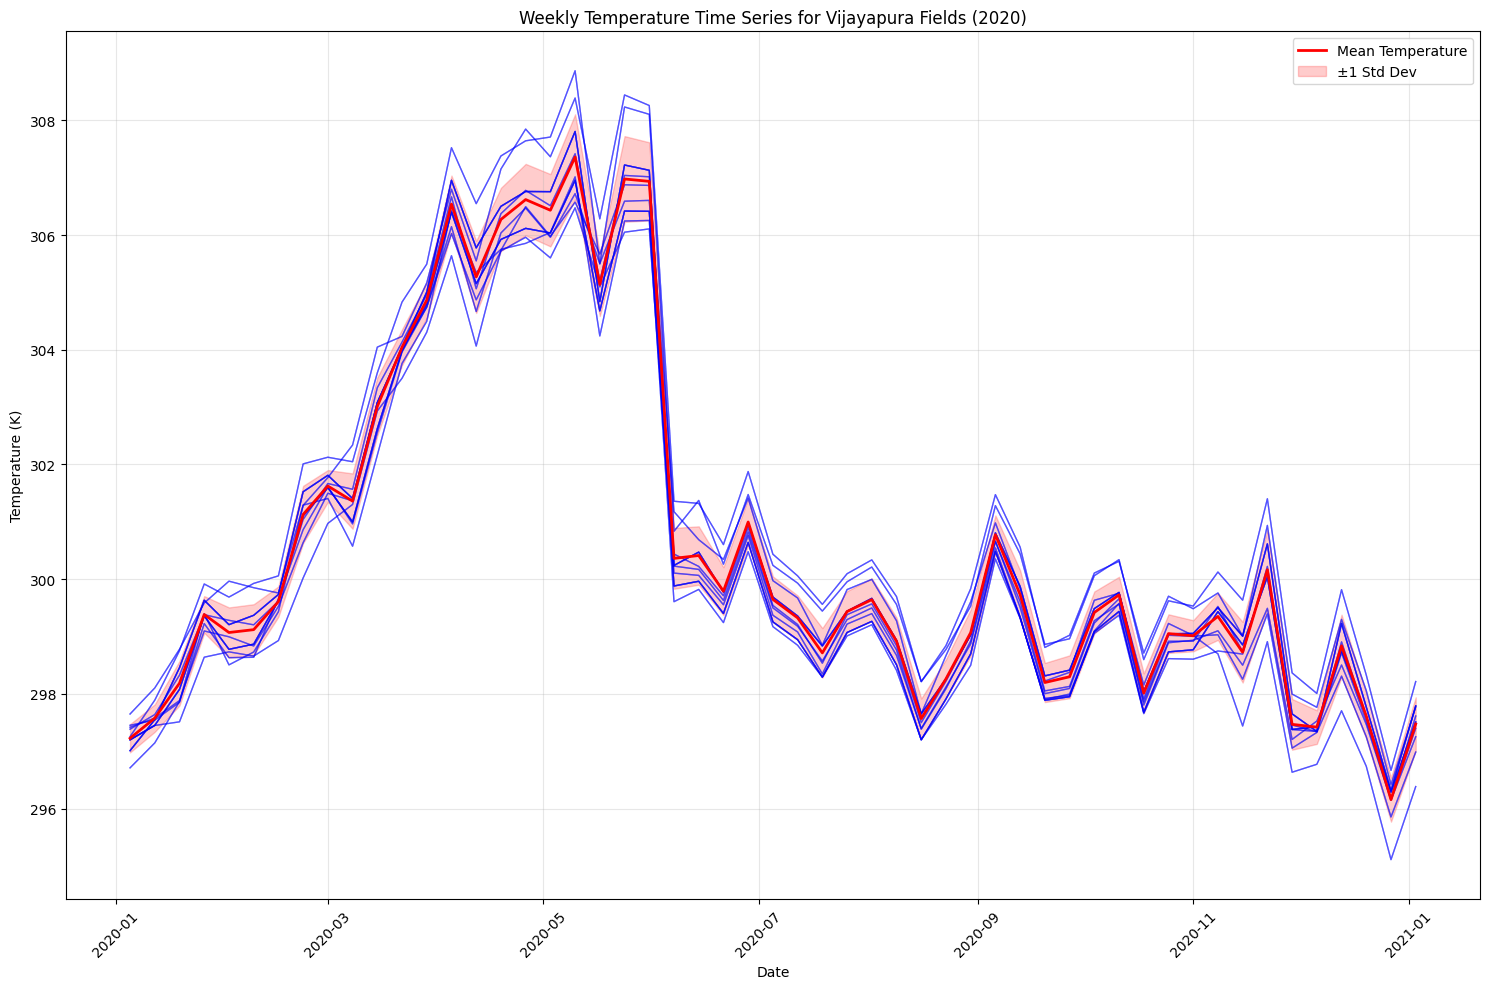

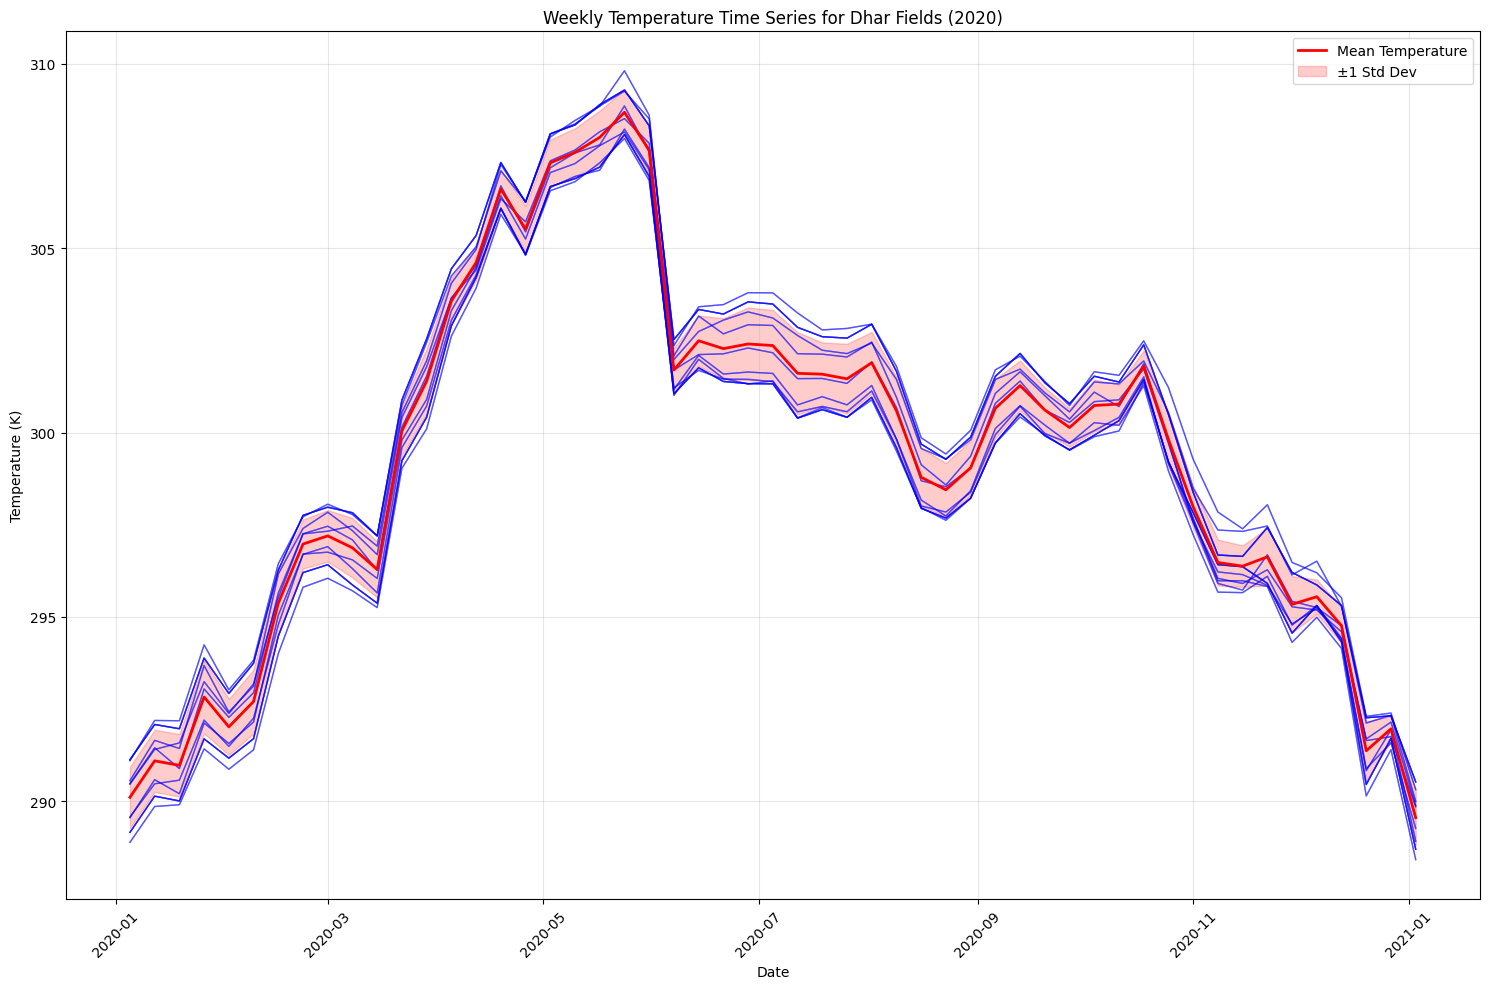

In [17]:
# Plot for Belagavi district
plot_district_temperature(belagavi_fields, ds_weekly, "Belagavi")

# Plot for Vijayapura district
plot_district_temperature(vijayapura_fields, ds_weekly, "Vijayapura")

# Plot for Dhar district
plot_district_temperature(dhar_fields, ds_weekly, "Dhar")

## 6. Comparing Temperature Patterns Across Multiple Districts

Let's compare temperature patterns across multiple districts by plotting their temperature time series side by side.

### Select Multiple Districts

In [18]:
# List of selected districts
selected_districts = ["Belagavi", "Vijayapura", "Dhar"]

# Corresponding field dataframes
district_fields = {
    "Belagavi": belagavi_fields,
    "Vijayapura": vijayapura_fields,
    "Dhar": dhar_fields
}

### Plot Temperature Patterns Across Districts

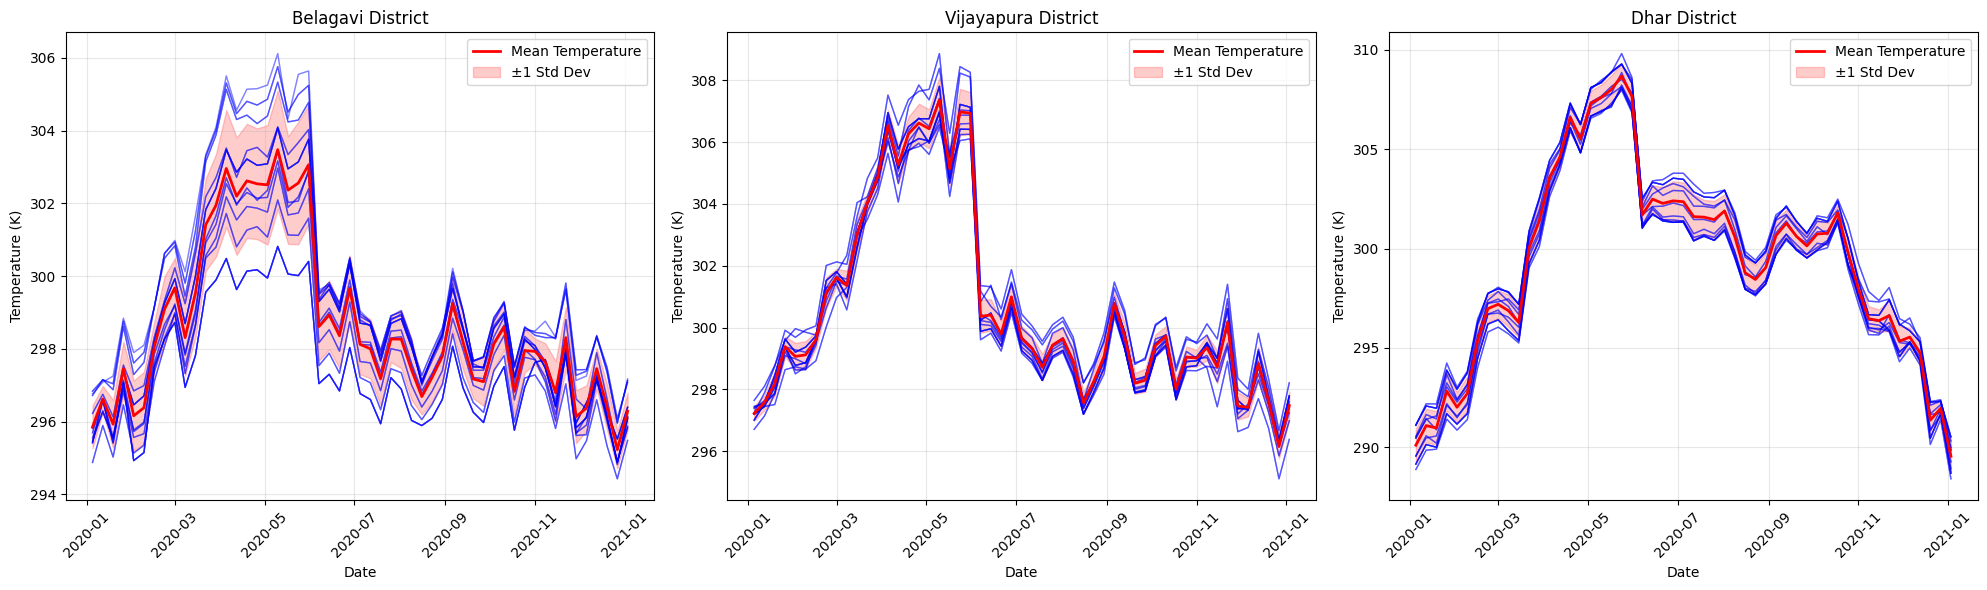

In [19]:
import pandas as pd

# Create a subplot for each district
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, district_name in zip(axes, selected_districts):
    fields_df = district_fields[district_name]
    
    # Extract time series for all fields
    time_series_list = []
    for _, row in fields_df.iterrows():
        geometry = row.geometry
        ts = extract_timeseries_for_centroid(ds_weekly, geometry)
        ts.name = f"Field {row.name}"
        time_series_list.append(ts)
    
    # Combine all series into a DataFrame
    df_temps = pd.concat(time_series_list, axis=1)
    
    # Plot all time series
    ax.plot(df_temps.index, df_temps.values, alpha=0.2, color='blue', linewidth=1)
    
    # Plot mean and standard deviation
    mean_temp = df_temps.mean(axis=1)
    std_temp = df_temps.std(axis=1)
    ax.plot(df_temps.index, mean_temp, color='red', linewidth=2, label='Mean Temperature')
    ax.fill_between(df_temps.index,
                    mean_temp - std_temp,
                    mean_temp + std_temp,
                    color='red',
                    alpha=0.2,
                    label='±1 Std Dev')
    
    # Customize plot
    ax.set_title(f'{district_name} District')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (K)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Lonboard - Scalable Dynamic Visualization on Maps

In [20]:
from lonboard import Map, PolygonLayer

In [24]:
karnataka_layer = PolygonLayer.from_geopandas(
    karnataka_districts,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[204, 251, 254],  # light blue
    get_line_color=[37, 36, 34],  # dark border color
)

madhyapradesh_layer = PolygonLayer.from_geopandas(
    madhyapradesh_districts,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[100, 251, 100],  # light blue
    get_line_color=[37, 36, 34],  # dark border color
)

fields_layer = PolygonLayer.from_geopandas(
    fields_gdf,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[100, 251, 100],  # light blue
    get_line_color=[37, 36, 34],  # dark border color
)

In [25]:
m = Map(layers=[karnataka_layer, madhyapradesh_layer, fields_layer])
m

Map(custom_attribution='', layers=(PolygonLayer(get_fill_color=[204, 251, 254], get_line_color=[37, 36, 34], g…